## SiMFS-Tk Example: Immobilized FRET II

This example demonstrates how to perform FRET experiments with SiMFS-Tk including two fluorophore simulation.

## Principle

Based on the immobilized FRET example I, we perform a similar simulation and pass the transferred photons from the donor to a second instance of ``simfs_ph2`` to simulate the acceptor fluorophore photophysics.

### Components

- ``simfs_ph2``
- ``simfs_cnf``
- ``simfs_spl``
- ``simfs_mix``

## Imports

In [1]:
import os
import numpy as np

from pysimfs import *
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


### Conformation generator

FRET efficiencies are generated from a two-state system:

In [2]:
states = {
        'on': {
            'from': 'N0',
            'rate': 200.0,
            'to': 'N1'
        },
        'off': {
            'from': 'N1',
            'rate': 100.0,
            'to': 'N0'
        }
    }

values = {
        'N0': 0.3,
        'N1': 0.7
    }   

cnf = Conformation(
    experiment_time=100,
    output='fret_E', 
    states=states, 
    values=values, 
    initial_state='N0'
)

### Donor dye

The standard static fluorophore writes photons to ``Dem`` and a final bleaching tag to ``bleach.dat``.

In [3]:
jablonskyD = {
        'bleach': {
            'from': 'T1',
            'rate': 1e+2,
            'to': 'X',
            'output': 'bleachD.dat'
        },
        'emi': {
            'from': 'S1',
            'output': 'Dem',
            'rate': 1e+8,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': 1e+5,
            'to': 'S1'
        },
        'isc': {
            'from': 'S1',
            'rate': 1e+5,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 1e+5,
            'to': 'S0'
        }
    }

ph2_donor = Fluorophore(
    initial_state='S0', 
    jablonsky=jablonskyD
)

### Transfer splitter

The transfer splitter takes the FRET efficiencies and the raw donor emission and splits the photons into ``transferred`` photons and ``not_transferred`` ones.


In [4]:
spl = Splitter(
    photon_input='Dem',
    efficiency_input='fret_E',
    accepted_output='transferred',
    rejected_output='not_transferred'
)

### Acceptor dye

The acceptor fluorophore needs some special setup: There is no direct excitation of the acceptor, so the rate at the ``exi`` edge is always 0. This however behaves like a non-exisiting edge, meaning that **S0** becomes a dead end and terminates the simulation imediately. So we need to add a *fake* edge ``keepalive`` that just points **S0** to **S0** with a non-zero rate. In this way the component keeps running. The excitation edge has an additional field ``trigger``. The trigger reads in time values from its input, in this case the transferred photons. If the graph is in a state that allows traversal of the triggered edge (i.e. is in **S0**) the trigger issues a transition along the ``exi`` edge at the time of the input trigger. This is like an absorption process of a single photon. If the graph is not in the ground state, a trigger event is passed on to the trigger-output ``rejected``. There is an additional ``efficiency`` option to accept only a fraction of arriving photons. We leave it at 1 for now.

The normal photon output of the acceptor is written to ``Aem.dat`` and a final bleaching tag is written to ``bleachA.dat``.

In [5]:
jablonskyA = {
        'bleach': {
            'from': 'T1',
            'rate': 1e+3,
            'to': 'X',
            'output': 'bleachA.dat'
        },
        'emi': {
            'from': 'S1',
            'output': 'Aem.dat',
            'rate': 1e+8,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': 0,
            'trigger': {
                'input': 'transferred',
                'output': 'rejected',
                'efficiency': 1
            },
            'to': 'S1'
        },
        'keepalive': {
            'from': 'S0',
            'to': 'S0',
            'rate': 1
        },
        'isc': {
            'from': 'S1',
            'rate': 1e+5,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 1e+5,
            'to': 'S0'
        }
    }

ph2_acceptor = Fluorophore(
    initial_state='S0', 
    jablonsky=jablonskyA
)

### Donor emission mixer

Finally we mix the photons that were not transferred with the photons rejected by the acceptor. Together they form the emission of the donor ``Dem.dat``. You could also drop the ``rejected`` photons directly and use only the ``not_transferred`` stream as donor emission directly.

In [6]:
mix = Mixer(
    inputs=['not_transferred', 'rejected'],
    output='Dem.dat'
)

## Running the simulation

Putting it together and running the simulation:

In [7]:
with Simulation() as S:
    
    S.add(cnf)
    S.add(ph2_donor)
    S.add(spl)
    S.add(ph2_acceptor)
    S.add(mix)
    
    log = S.run()
    res = S.get_results()

Folder ./pysimfs_data exists.
Started simulation with 5 component processes.
Simulation completed after 0.51 seconds.


### Inspecting the results

In [8]:
Dem = res['Dem.dat']
Aem = res['Aem.dat']

We use the bleaching times to trim our data. To show the whole data, we take the time window from 0 to the last bleaching time or the end of the experiment time, for FRET calculation we take only the time window from 0 to the first bleaching event.

In [9]:
bleach = list(res['bleachA.dat'])+list(res['bleachD.dat'])
bleach1 = min([100]+bleach)
bleach2 = max([0]+bleach)

In [10]:
t = np.linspace(0, bleach2, int(bleach2*1000))

histD, _ = np.histogram(Dem, t)
histA, _ = np.histogram(Aem, t)

## You can see the alternating states in the photon time trace.

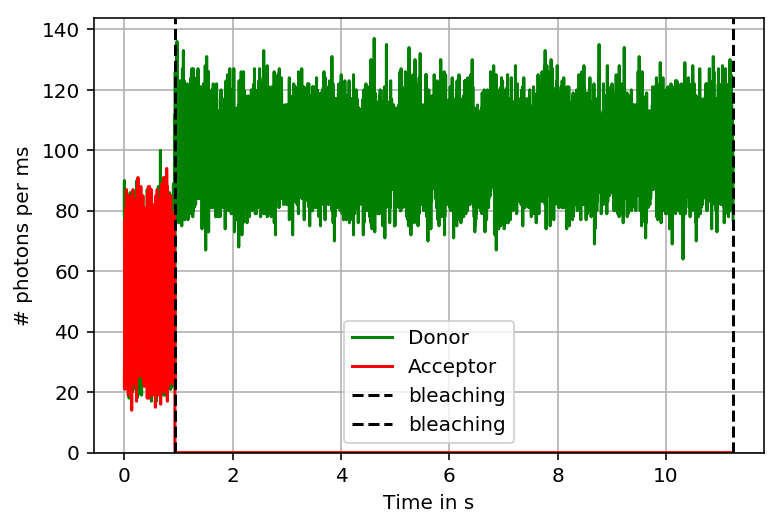

In [11]:
plt.plot(t[:-1], histD, color='g', label='Donor')
plt.plot(t[:-1], histA, color='r', label='Acceptor')

for b in (bleach1, bleach2):
    if (b<100):
        plt.axvline(b, ls='--', color='k', label='bleaching')

plt.grid()
plt.ylim(0,)

plt.xlabel('Time in s')
plt.ylabel('# photons per ms')
plt.legend()

### FRET Histogram

A quick FRET histogram shows the two conformational states with proportions representing the transition rates and resulting state population in the ``simfs_cnf`` simulation.

In [12]:
Dem = Dem[Dem<bleach1]
Aem = Aem[Aem<bleach1]

t = np.linspace(0, bleach1, int(bleach1*1000))

histD, _ = np.histogram(Dem, t)
histA, _ = np.histogram(Aem, t)

E = histA/(histA+histD)
histE, binsE = np.histogram(E, np.linspace(0, 1, 50))

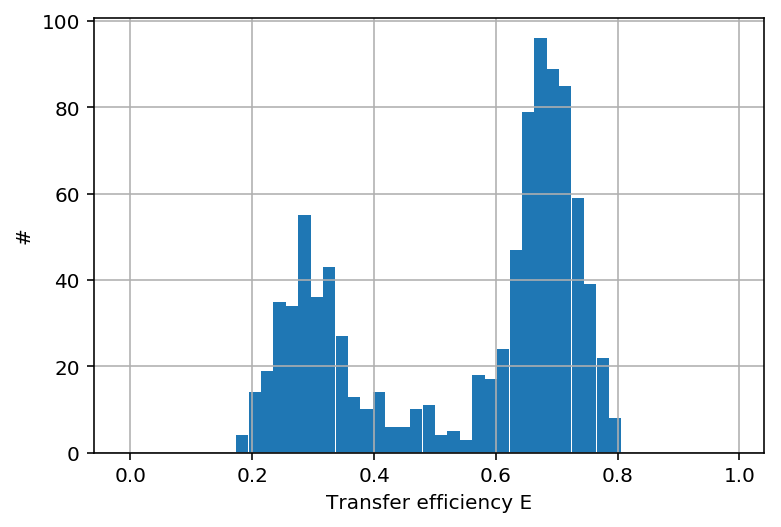

In [13]:
plt.bar(binsE[:-1], histE, width=1/len(binsE))
plt.xlabel('Transfer efficiency E')
plt.ylabel('#')
plt.grid()

## Correlation

We can look further into the data with a quick correlation. We are going to use [``pycorrelate``](https://pypi.org/project/pycorrelate/) to do so:

In [14]:
from pycorrelate import pcorrelate

In [15]:
tau = np.logspace(-9, -1, 100)
corDD = pcorrelate(Dem, Dem, tau, normalize=True)
corAA = pcorrelate(Aem, Aem, tau, normalize=True)
corDA = pcorrelate(Dem, Aem, tau, normalize=True)

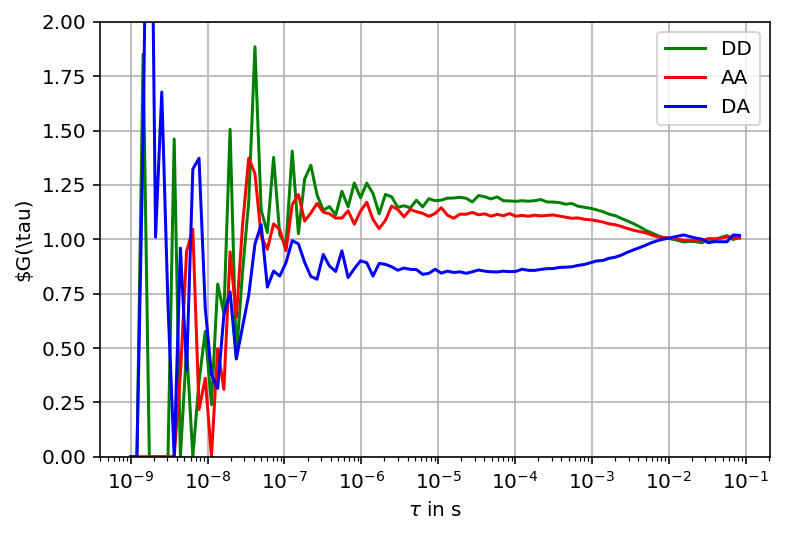

In [16]:
plt.semilogx(tau[:-1], corDD, color='g', label='DD')
plt.semilogx(tau[:-1], corAA, color='r', label='AA')
plt.semilogx(tau[:-1], corDA, color='b', label='DA')
plt.ylim(0, 2)
plt.grid()
plt.legend()
_ = plt.xlabel(r'$\tau$ in s')
_ = plt.ylabel(r'$G(\tau)')

You can see the fluctuation in both channels as well as the anti-correlation in the cross correlation curve. At higher powers (if you increase the excitaion rate), triplet fluctuations become visible as well.